In [1]:
from tkinter import filedialog
from tkinter import Tk
import pandas as pd

root = Tk()
root.withdraw()

# Read data
csv_file_path = filedialog.askopenfilename(title="Select Real-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Sim_File_path = filedialog.askopenfilename(title="Select Sim-result file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Define data
df_setting = pd.read_excel(Setting_File_path)
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

df = pd.read_csv(csv_file_path)
dfsim = pd.read_csv(Sim_File_path)

# Mode check @ Real-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)


Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


In [2]:
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import math

def prepare_kfold_data(df, target_var, feature_vars):
    X = df[feature_vars]
    y = df[target_var]
    return X, y

def objective(trial, X, y):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, objective='reg:squarederror')
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        mse_scores.append(mse)
        
    return np.mean(mse_scores)

def optimize_hyperparameters(X, y):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=1)
    return study.best_params

def evaluate_model(X, y, best_model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        rmse_scores.append(math.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
        
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"Average RMSE: {avg_rmse}, Average R2: {avg_r2}")

if __name__ == "__main__":
    X, y = prepare_kfold_data(df, target_variable, feature_vars)
    best_params = optimize_hyperparameters(X, y)
    best_model = XGBRegressor(**best_params, objective='reg:squarederror')
    evaluate_model(X, y, best_model)


[I 2023-09-05 18:35:45,564] A new study created in memory with name: no-name-9bc07c43-e739-491e-a361-d79ce57beb9d
[I 2023-09-05 18:35:57,940] Trial 0 finished with value: 2.7349626658236827 and parameters: {'n_estimators': 124, 'learning_rate': 0.14554810744103655, 'max_depth': 4}. Best is trial 0 with value: 2.7349626658236827.


Average RMSE: 1.6536951811880936, Average R2: 0.9920240957436466


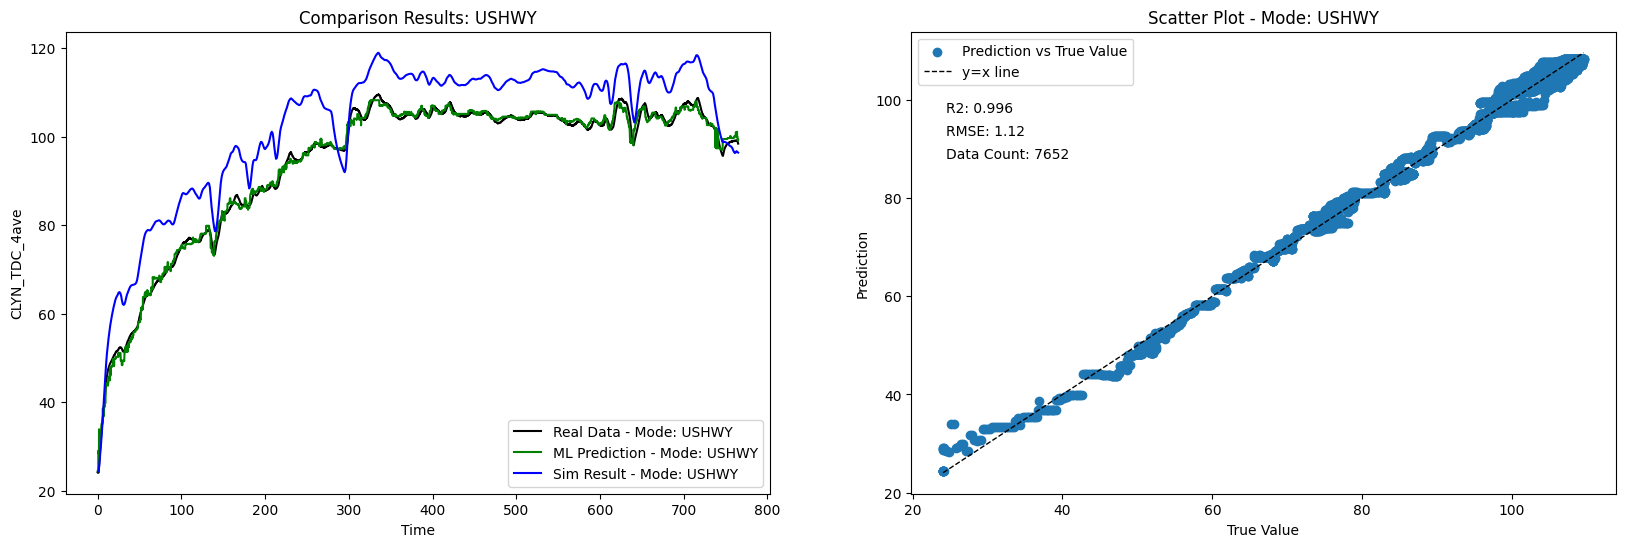

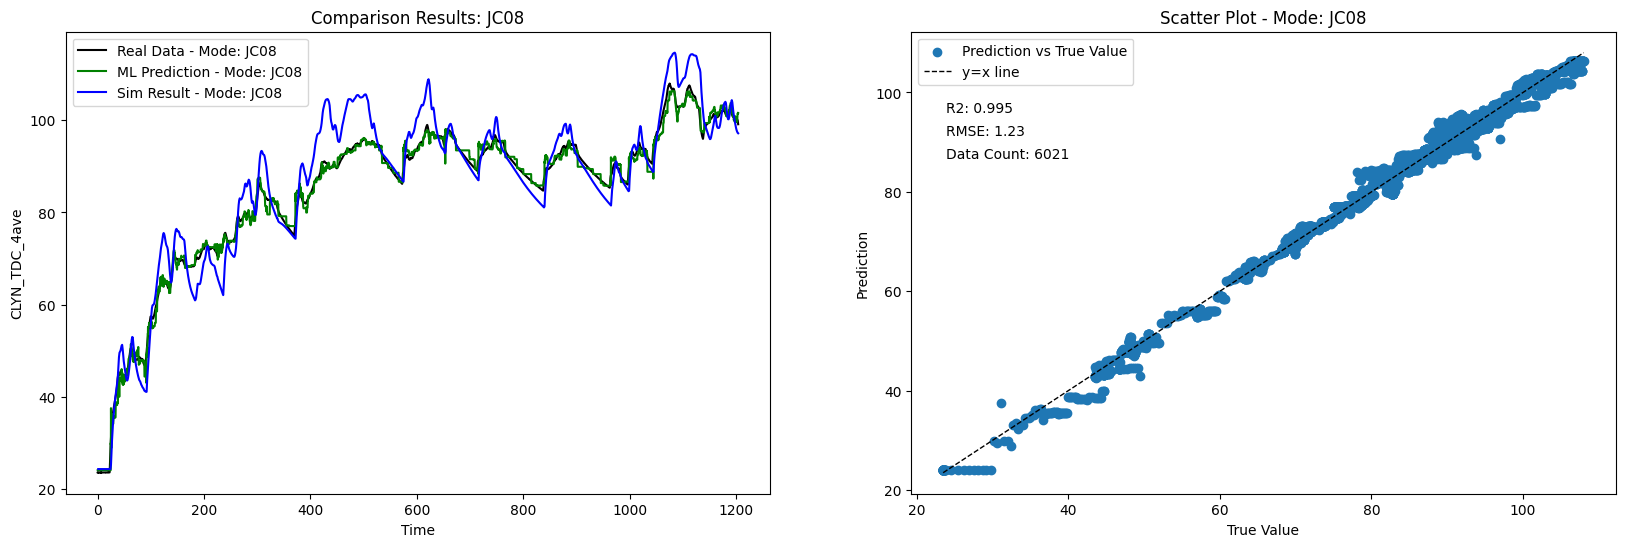

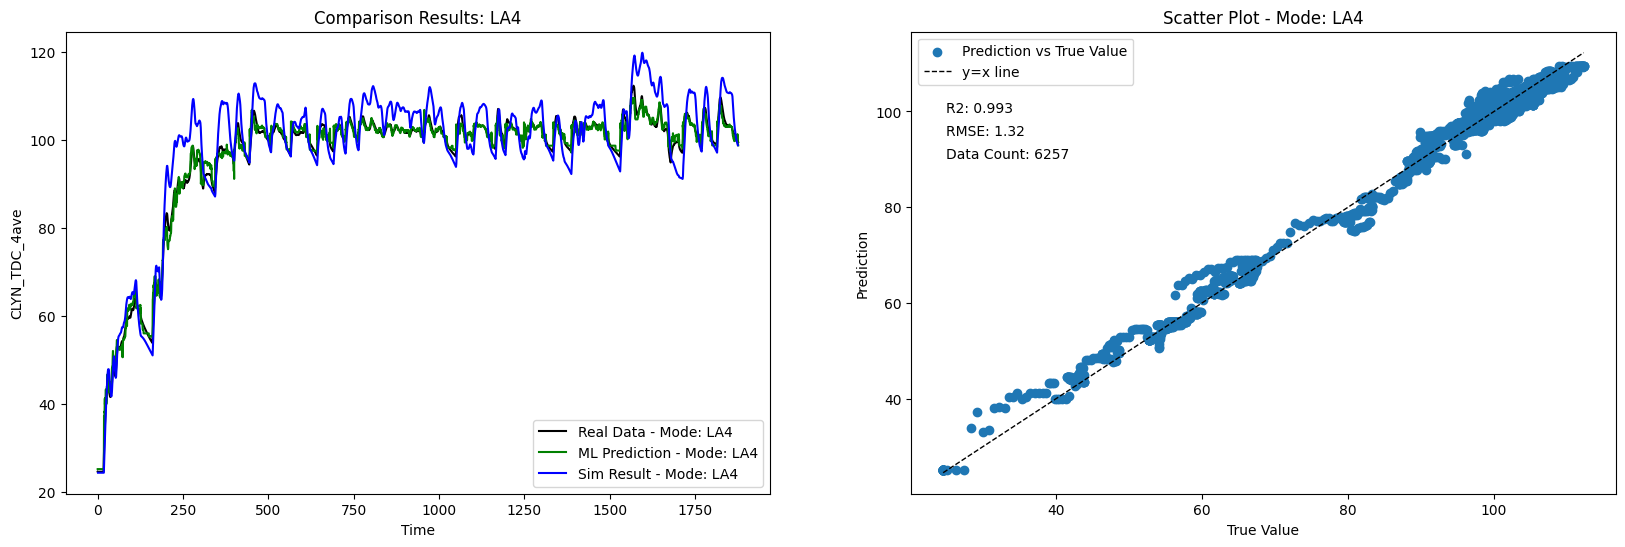

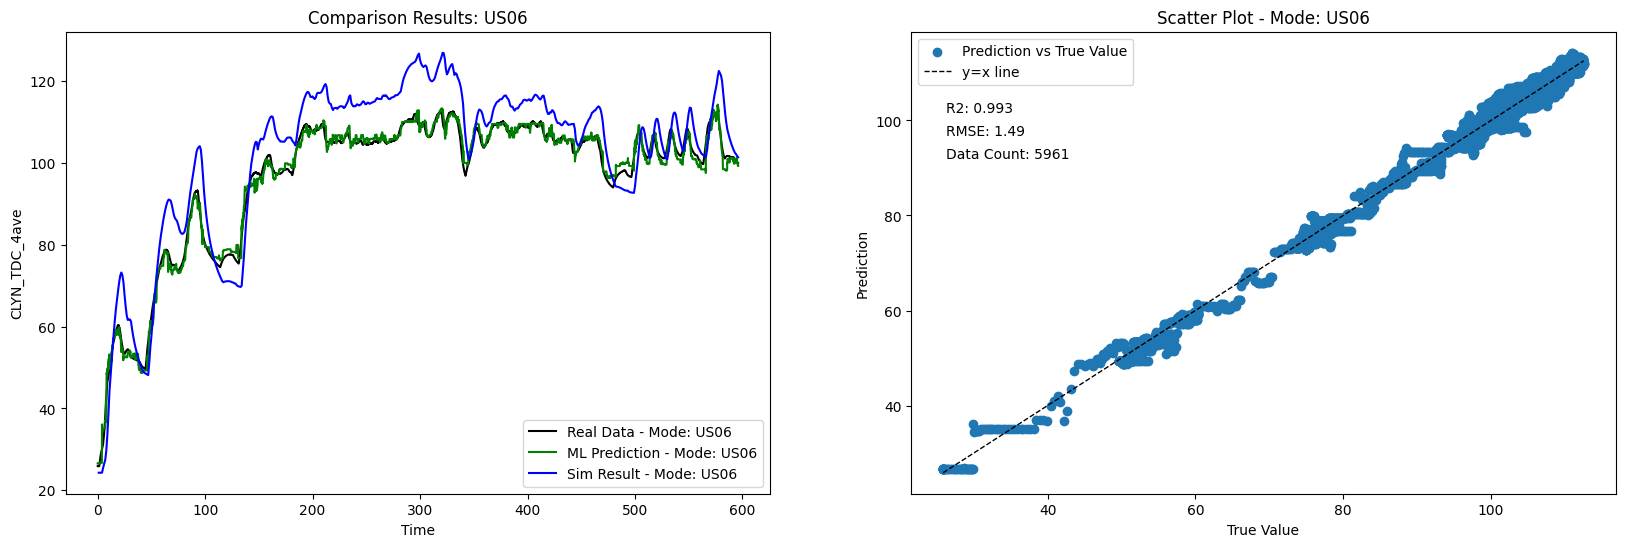

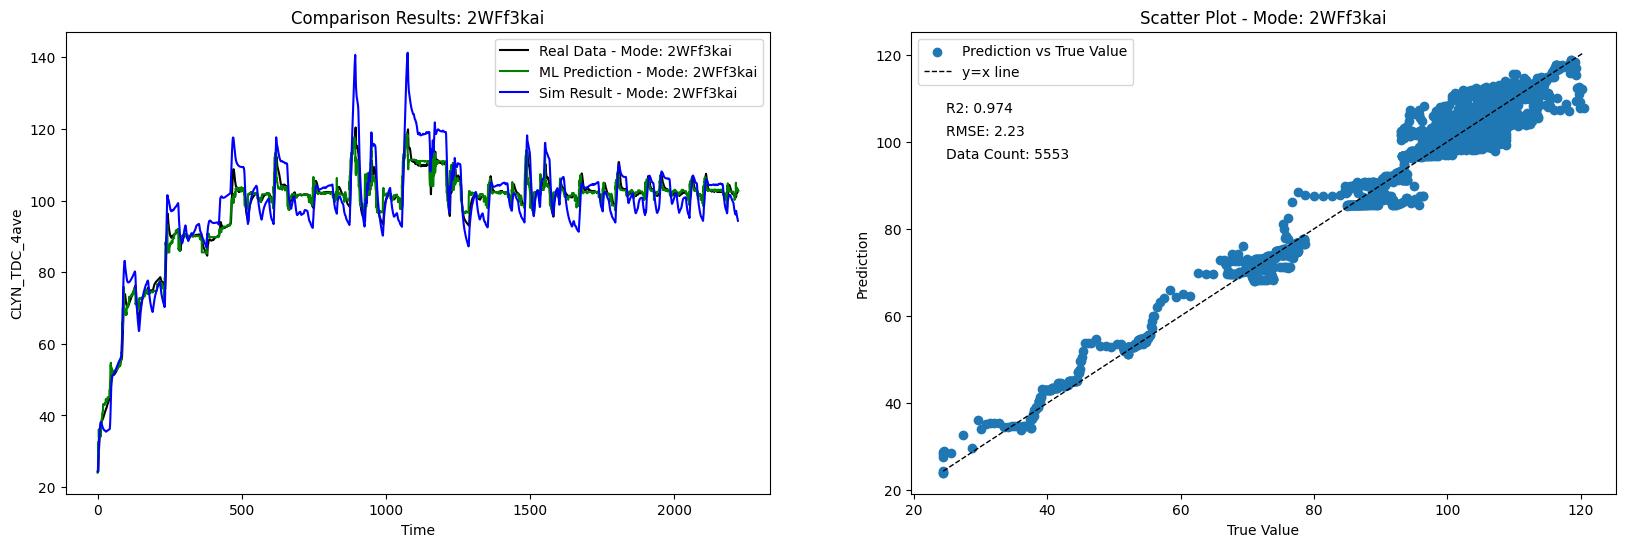

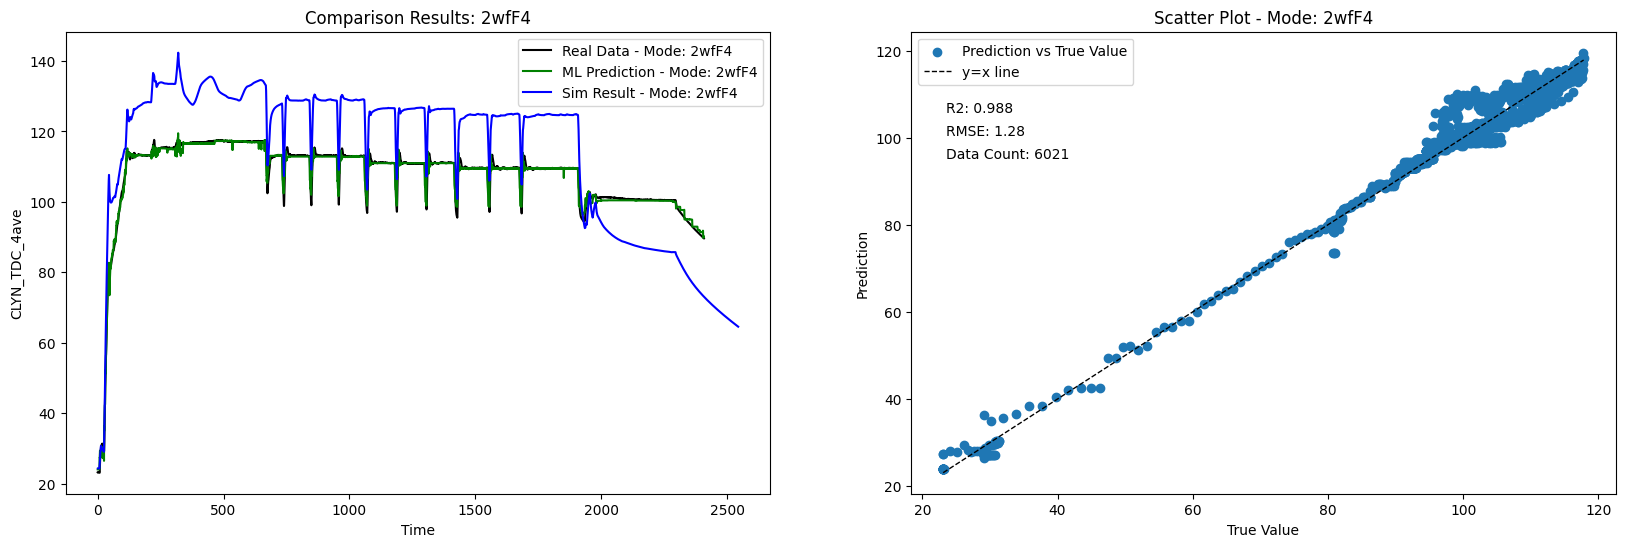

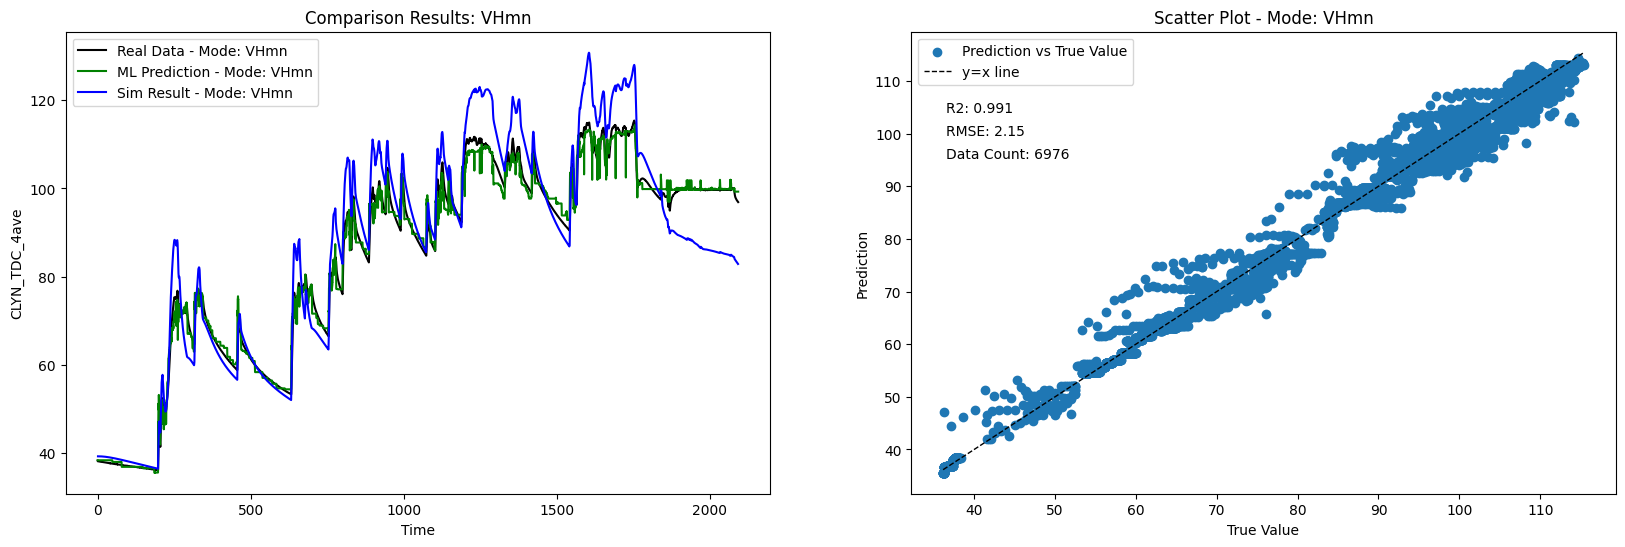

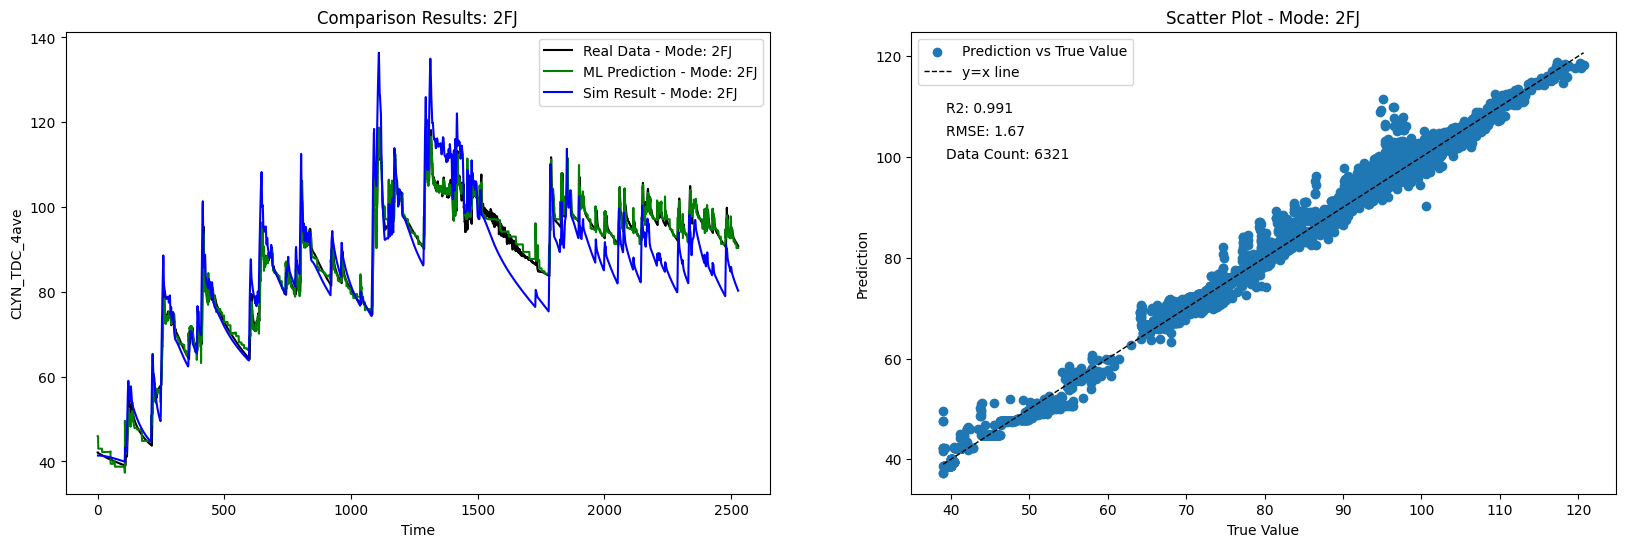

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math

# 特徴量と目的変数で機械学習予測
def plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes):
    for test_mode in unique_modes:
        # 1行2列 subplot
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))
        
        # Data divide
        train_df = df[df['Mode'] != test_mode]
        test_df = df[df['Mode'] == test_mode]
        
        # training
        X_train = train_df[feature_vars]
        y_train = train_df[target_variable]
        
        # Predict
        X_test = test_df[feature_vars]
        y_test = test_df[target_variable]
        y_pred = best_model.predict(X_test)
        
        # Sim data
        filtered_dfsim = dfsim[dfsim['Mode'] == test_mode]
        sim_time_data = filtered_dfsim["time"]
        sim_target = filtered_dfsim[target_variable]
        
        # Time series plot
        axs[0].plot(test_df['time'], y_test, label=f'Real Data - Mode: {test_mode}', color='black')
        axs[0].plot(test_df['time'], y_pred, label=f'ML Prediction - Mode: {test_mode}', color='green')
        axs[0].plot(sim_time_data, sim_target, label=f'Sim Result - Mode: {test_mode}', color='blue')
        
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel(target_variable)
        axs[0].set_title(f"Comparison Results: {test_mode}")
        axs[0].legend()
        
        # Scatter Plot
        r2_val = r2_score(y_test, y_pred)
        rmse_val = math.sqrt(mean_squared_error(y_test, y_pred))
        data_count = len(y_test)
        
        axs[1].scatter(y_test, y_pred, label=f'Prediction vs True Value')
        axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='y=x line')
        axs[1].set_xlabel('True Value')
        axs[1].set_ylabel('Prediction')
        axs[1].set_title(f'Scatter Plot - Mode: {test_mode}')
        axs[1].legend()
        axs[1].text(0.05, 0.85, f'R2: {r2_val:.3f}', transform=axs[1].transAxes, verticalalignment='top')
        axs[1].text(0.05, 0.80, f'RMSE: {rmse_val:.2f}', transform=axs[1].transAxes, verticalalignment='top')
        axs[1].text(0.05, 0.75, f'Data Count: {data_count}', transform=axs[1].transAxes, verticalalignment='top')
        
        plt.show()

plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes)


In [9]:
for i, pred in enumerate(predictions):
    y_test = pred["y_test"]
    y_pred = pred["y_pred"]
    y_train = pred["y_train"]
    y_train_pred = pred["y_train_pred"]
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_pred)
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = math.sqrt(mean_squared_error(y_test, y_pred))

    # データ数を取得
    n_train = len(y_train)
    n_test = len(y_test)
    
    fig, axs = plt.subplots(1, 3, figsize=(36, 6))
    
    # 訓練データのScatterプロット
    axs[0].scatter(y_train, y_train_pred, label='Train Prediction vs True Value')
    axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1, label='y=x line')
    axs[0].set_xlabel('True Value')
    axs[0].set_ylabel('Prediction')
    axs[0].set_title(f'Scatter Plot_Train data{i+1}')
    axs[0].legend()
    axs[0].text(0.05, 0.85, f'R2: {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.80, f'RMSE: {rmse_train:.2f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.75, f'Data Count: {n_train}', transform=axs[0].transAxes, verticalalignment='top')

    # テストデータのScatterプロット
    axs[1].scatter(y_test, y_pred, label='Test Prediction vs True Value')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='y=x line')
    axs[1].set_xlabel('True Value')
    axs[1].set_ylabel('Prediction')
    axs[1].set_title(f'Scatter Plot_Test data{i+1}')
    axs[1].legend()
    axs[1].text(0.05, 0.85, f'R2: {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.80, f'RMSE: {rmse_test:.2f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.75, f'Data Count: {n_test}', transform=axs[1].transAxes, verticalalignment='top') 
    
    # True vs Prediction のプロット
    axs[2].plot(range(len(y_test)), y_test, label='True Value', lw=1)
    axs[2].plot(range(len(y_test)), y_pred, label='Prediction', lw=1)
    axs[2].set_xlabel('Data Index')
    axs[2].set_ylabel('Target Variable')
    axs[2].legend()
    axs[2].set_title('True vs Prediction - Test Data')
    
    plt.show()


NameError: name 'predictions' is not defined